In [ ]:
# ===========================
# STEP 1: Upload Files in Colab
# ===========================
from google.colab import files
import pandas as pd

uploaded = files.upload()  # Select all zonix_*.csv files here

Saving zonix_employee_shifts.csv to zonix_employee_shifts (2).csv
Saving zonix_equipment_logs.csv to zonix_equipment_logs (2).csv
Saving zonix_incompatibility_rules.csv to zonix_incompatibility_rules (2).csv
Saving zonix_inventory_snapshots.csv to zonix_inventory_snapshots (2).csv
Saving zonix_item_movements.csv to zonix_item_movements (2).csv
Saving zonix_order_picking_paths.csv to zonix_order_picking_paths (2).csv
Saving zonix_shipment_logs.csv to zonix_shipment_logs (2).csv
Saving zonix_storage_zones.csv to zonix_storage_zones (2).csv
Saving zonix_warehouse_items.csv to zonix_warehouse_items (2).csv
Saving zonix_zone_temperatures.csv to zonix_zone_temperatures (2).csv


In [ ]:

# ===========================
# STEP 2: Load CSV Files
# ===========================
warehouse_items = pd.read_csv("zonix_warehouse_items.csv")   # SKU master data
storage_zones = pd.read_csv("zonix_storage_zones.csv")       # Zone details
inventory_snapshots = pd.read_csv("zonix_inventory_snapshots.csv")  # On-hand qty
shipment_logs = pd.read_csv("zonix_shipment_logs.csv")       # Shipment history
incompat_rules = pd.read_csv("zonix_incompatibility_rules.csv")     # Incompatibility
# Optional extra data
employee_shifts = pd.read_csv("zonix_employee_shifts.csv")
equipment_logs = pd.read_csv("zonix_equipment_logs.csv")
item_movements = pd.read_csv("zonix_item_movements.csv")
order_paths = pd.read_csv("zonix_order_picking_paths.csv")
zone_temps = pd.read_csv("zonix_zone_temperatures.csv")

In [ ]:
# ===========================
# STEP 3: Standardize Column Names
# ===========================
for df in (warehouse_items, storage_zones, inventory_snapshots, shipment_logs, incompat_rules):
    df.columns = [c.lower() for c in df.columns]

In [ ]:
# ===========================
# STEP 4: Clean & Normalize Data
# ===========================

# Standardize dimension column names (remove spaces and lowercase)
warehouse_items.columns = [c.strip().lower().replace(" ", "_") for c in warehouse_items.columns]

# Compute volume in cubic meters from cm dimensions
warehouse_items['volume_m3_per_unit'] = (
    warehouse_items['length_cm'] *
    warehouse_items['width_cm'] *
    warehouse_items['height_cm']
) / 1_000_000  # cm³ → m³

# Handle hazardous, fragile, and stackable flags
for col in ['hazadeous_t/f', 'fragile_t/f', 'stackable_t/f']:
    if col in warehouse_items.columns:
        warehouse_items[col] = warehouse_items[col].astype(str).str.strip().str.lower().map({
            't': True, 'true': True, '1': True,
            'f': False, 'false': False, '0': False
        }).fillna(False)

# Drop duplicates
warehouse_items.drop_duplicates(subset=['item_id'], keep='last', inplace=True)

In [ ]:
# ===========================
# STEP 5: Aggregate Shipment History
# ===========================
shipment_logs['timestamp'] = pd.to_datetime(shipment_logs['timestamp'], errors='coerce')

recent_days = 90
cutoff = pd.Timestamp.now() - pd.Timedelta(days=recent_days)
ship_recent = shipment_logs[shipment_logs['timestamp'] >= cutoff]

sku_moves = ship_recent.groupby('item_id').agg(
    movement_count=('shipment_id', 'nunique'),
    total_units_moved=('quantity', 'sum'),
    last_movement=('timestamp', 'max')
).reset_index()

In [ ]:
# ===========================
# STEP 6: Build SKU-Level Dataset
# ===========================
sku_level = warehouse_items.merge(sku_moves, on='item_id', how='left') # Merging on 'item_id'

# Merge with warehouse_items DataFrame to get on-hand quantity per item
# inventory_snapshots is aggregated by zone, so using warehouse_items DataFrame instead

# Check if the specified columns exist in warehouse_items DataFrame
on_hand_col_options = ['current_on_hand_qty'] # Only 'current_on_hand_qty' is in warehouse_items
on_hand_col = None
for col in on_hand_col_options:
    if col in warehouse_items.columns:
        on_hand_col = col
        break

if on_hand_col:
    print(f"Using column '{on_hand_col}' from warehouse_items DataFrame as on-hand quantity.")
    # Directly use the column from warehouse_items as it's already merged
    sku_level['on_hand_units'] = sku_level[on_hand_col]
else:
    print("Warning: No suitable on-hand quantity column found in the warehouse_items DataFrame. Assuming 0 on-hand units for all items.")
    sku_level['on_hand_units'] = 0


sku_level.fillna({'on_hand_units': 0, 'movement_count': 0, 'total_units_moved': 0}, inplace=True)
sku_level['on_hand_units'] = sku_level['on_hand_units'].astype(int)
if 'volume_m3_per_unit' in sku_level.columns:
    sku_level['total_on_hand_volume_m3'] = sku_level['on_hand_units'] * sku_level['volume_m3_per_unit']

display(sku_level.head())

Using column 'current_on_hand_qty' from warehouse_items DataFrame as on-hand quantity.


,item_id,category,weight_kg,length_cm,width_cm,height_cm,stackable,fragile,hazardous,temperature_range,current_on_hand_qty,volume_m3_per_unit,movement_count,total_units_moved,last_movement,on_hand_units,total_on_hand_volume_m3
0,ITM0000,Home Goods,25.51,28,69,14,True,False,True,Ambient,112,0.027048,0.0,0.0,NaT,112,3.029376
1,ITM0001,Beverages,41.41,45,72,53,True,True,True,Ambient,445,0.171720,0.0,0.0,NaT,445,76.415400
2,ITM0002,Frozen Foods,16.34,38,95,36,False,True,False,Frozen,358,0.129960,0.0,0.0,NaT,358,46.525680
3,ITM0003,Beverages,44.83,69,11,41,True,False,False,Frozen,280,0.031119,0.0,0.0,NaT,280,8.713320
4,ITM0004,Beverages,19.77,91,97,30,False,True,True,Frozen,116,0.264810,1.0,20.0,2025-07-24,116,30.717960


In [ ]:
# ===========================
# STEP 7: Save Cleaned Data
# ===========================
sku_level.to_csv("sku_level_cleaned.csv", index=False)
storage_zones.to_csv("zone_level_cleaned.csv", index=False)
incompat_rules.to_csv("incompatibility_rules_cleaned.csv", index=False)

print("✅ Cleaned files saved: sku_level_cleaned.csv, zone_level_cleaned.csv, incompatibility_rules_cleaned.csv")


✅ Cleaned files saved: sku_level_cleaned.csv, zone_level_cleaned.csv, incompatibility_rules_cleaned.csv


In [ ]:
# ===========================
# PHASE 3: LP Model for Storage Allocation
# ===========================

import pulp

# Step 1: Pre-filter feasible SKU–zone pairs
possible_pairs = []
for _, sku_row in sku_level.iterrows():
    for _, zone_row in zone_df.iterrows():
        # Check volume constraint
        if sku_row['volume_m3_per_unit'] <= zone_row['max_volume_m3']:
            # Check temperature constraint
            if ('temperature_range' not in sku_row) or \
               (zone_row.get('temperature_class') is None) or \
               (sku_row['temperature_range'] == zone_row['temperature_class']):
                possible_pairs.append((sku_row['item_id'], zone_row['zone_id']))

print(f"Total possible pairs: {len(possible_pairs)} (down from {len(sku_level) * len(zone_df)})")

Total possible pairs: 1649 (down from 5000)


In [ ]:
# ----------------------------------------------------------
# STEP 2: Create decision variables only for feasible pairs
# ----------------------------------------------------------
x = pulp.LpVariable.dicts("alloc", possible_pairs, cat='Binary')

In [ ]:
# -------------------------------------------------------------------
# STEP 3: Define the objective (example: minimize weighted distance)
# -------------------------------------------------------------------

model = pulp.LpProblem("Warehouse_Allocation", pulp.LpMinimize)
model += pulp.lpSum([
    movement_priority.get(sku, 1) * zone_distance.get(zone, 1) * x[(sku, zone)]
    for sku, zone in possible_pairs
])


In [ ]:
# ---------------------------------------
# STEP 4: Capacity Constraints Per Zone
# ---------------------------------------
for _, zone_row in zone_df.iterrows():
    model += pulp.lpSum([
        sku_level.loc[sku_level['item_id'] == sku, 'volume_m3_per_unit'].values[0] * x[(sku, zone_row['zone_id'])]
        for sku, z in possible_pairs if z == zone_row['zone_id']
    ]) <= zone_row['max_volume_m3']

In [ ]:
# -----------------------------------------------
# STEP 5: Each SKU assigned to exactly one zone
# -----------------------------------------------
for _, sku_row in sku_level.iterrows():
    model += pulp.lpSum([
        x[(sku_row['item_id'], zone)]
        for sku, zone in possible_pairs if sku == sku_row['item_id']
    ]) == 1

In [ ]:
# --------------------------------------------------
# STEP 6: Solve with time limit (e.g., 60 seconds)
# --------------------------------------------------

print("Solving model (time limit = 60s)...")
model.solve(pulp.PULP_CBC_CMD(msg=1, timeLimit=60))

print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Total cost: {pulp.value(model.objective)}")


Solving model (time limit = 60s)...
Status: Optimal
Total cost: 14366.0


In [ ]:
# ---------------------------
# STEP 7: Extract The Results
# ---------------------------
allocations = []
for (sku, zone) in possible_pairs:
    if pulp.value(x[(sku, zone)]) == 1:
        allocations.append({
            "sku": sku,
            "zone_id": zone,
            "volume_m3": sku_level.loc[sku_level['item_id'] == sku, 'volume_m3_per_unit'].values[0],
            "priority": movement_priority.get(sku, 1)
        })

alloc_df = pd.DataFrame(allocations)

# Merge with zone_df to get the 'near_loading_dock' information
alloc_df = alloc_df.merge(zone_df[['zone_id', 'near_loading_dock']], on='zone_id', how='left')

# Add a 'distance' column using the zone_distance dictionary
alloc_df['distance'] = alloc_df['zone_id'].map(zone_distance)


alloc_df.to_csv("optimal_allocations.csv", index=False)
print("Optimal allocations saved to 'optimal_allocations.csv'")

Optimal allocations saved to 'optimal_allocations.csv'


In [ ]:
from google.colab import files
files.download("optimal_allocations.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install the pulp library
%pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 86.2 MB/s eta 0:00:00


In [ ]:
# -------------------------------------------------------------------
# Define movement priority and zone distance dictionaries
# (These are placeholder values and should be replaced with actual data if available)
# -------------------------------------------------------------------

# Example: Define SKU priority based on total units moved (higher movement = higher priority)
# Using total_units_moved directly as priority for now
movement_priority = sku_level.set_index('item_id')['total_units_moved'].to_dict()

# Example: Define zone distance based on proximity to loading dock
# Assuming 'near_loading_dock' = True means lower distance (e.g., 1) and False means higher distance (e.g., 10)
zone_distance = zone_df.set_index('zone_id')['near_loading_dock'].apply(lambda x: 1 if x else 10).to_dict()

print("Movement Priority Dictionary created.")
print("Zone Distance Dictionary created.")

Movement Priority Dictionary created.
Zone Distance Dictionary created.


In [ ]:
# ---------------------------
# Model Visualisations
# ---------------------------


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load allocations (post-optimization)
alloc_df = pd.read_csv("optimal_allocations.csv")

# Load supporting data
sku_df = pd.read_csv("zonix_warehouse_items.csv")
zone_df = pd.read_csv("zonix_storage_zones.csv")
zone_temp_df = pd.read_csv("zonix_zone_temperatures.csv")
movements_df = pd.read_csv("zonix_item_movements.csv")

# Merge needed data
alloc_df = alloc_df.merge(sku_df[['item_id', 'hazardous', 'category']], left_on="sku", right_on="item_id", how="left")
alloc_df = alloc_df.merge(zone_df, on="zone_id", how="left")

/tmp/ipython-input-3262729989.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=utilization, x='zone_id', y='utilization_pct', palette='viridis')


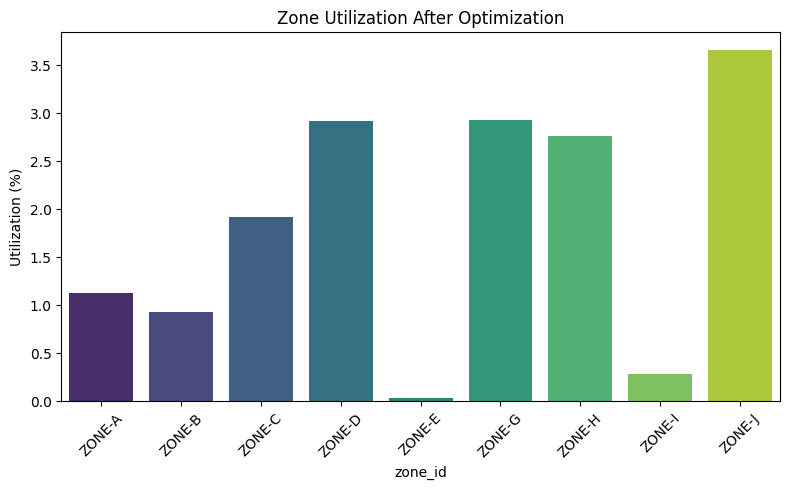

In [ ]:
# ----------------------------
# 1. Zone Utilization %
# ----------------------------
utilization = alloc_df.groupby('zone_id').agg({
    'volume_m3': 'sum',
    'max_volume_m3': 'first'
}).reset_index()
utilization['utilization_pct'] = (utilization['volume_m3'] / utilization['max_volume_m3']) * 100

plt.figure(figsize=(8,5))
sns.barplot(data=utilization, x='zone_id', y='utilization_pct', palette='viridis')
plt.title("Zone Utilization After Optimization")
plt.ylabel("Utilization (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

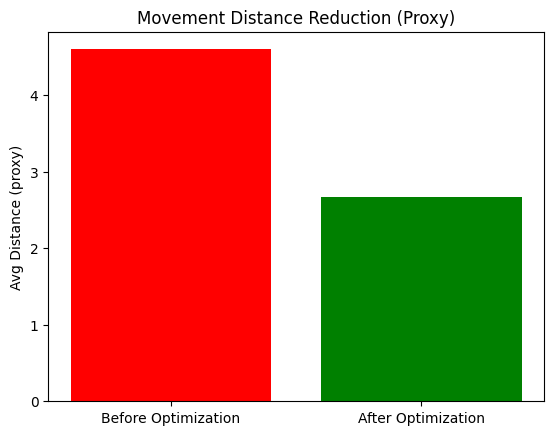

In [ ]:
# ----------------------------
# 2. Distance Reduction
# ----------------------------

# Calculate average 'before optimization' distance using the zone_distance dictionary
# Map the zone_id in movements_df to the distance in zone_distance
movements_df['zone_distance'] = movements_df['zone_id'].map(zone_distance)
avg_before = movements_df['zone_distance'].mean()

# Calculate average 'after optimization' distance using the 'distance' column in alloc_df
avg_after = alloc_df['distance'].mean()

plt.bar(["Before Optimization", "After Optimization"], [avg_before, avg_after], color=['red', 'green'])
plt.ylabel("Avg Distance (proxy)") # Changed ylabel to reflect proxy distance
plt.title("Movement Distance Reduction (Proxy)") # Changed title to reflect proxy distance
plt.show()

/tmp/ipython-input-1798850559.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=hazardous_df, x='zone_id', palette='Reds')


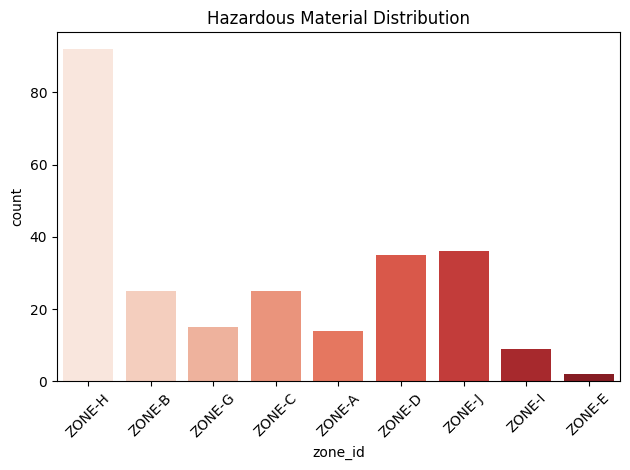

In [ ]:
# ----------------------------
# 3. Hazardous Material Separation
# ----------------------------
hazardous_df = alloc_df[alloc_df['hazardous'] == True]
sns.countplot(data=hazardous_df, x='zone_id', palette='Reds')
plt.title("Hazardous Material Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

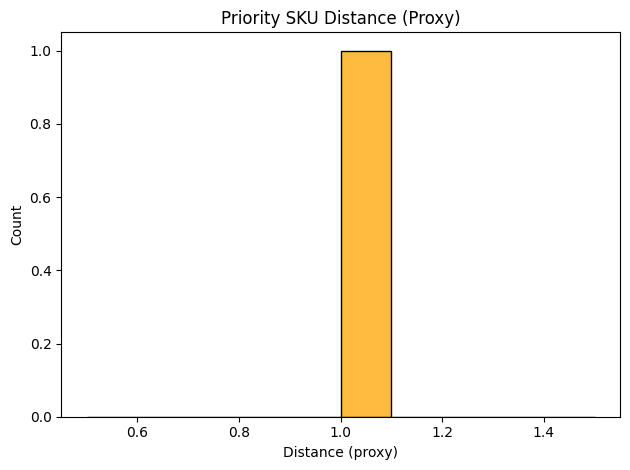

In [ ]:
# ----------------------------
# 4. Priority SKUs Near Exit
# ----------------------------
priority_df = alloc_df[alloc_df['priority'] == 1]
sns.histplot(priority_df['distance'], bins=10, color='orange')
plt.title("Priority SKU Distance (Proxy)") # Changed title to reflect proxy distance
plt.xlabel("Distance (proxy)") # Changed xlabel to reflect proxy distance
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
# 5. Zone Temperature Compatibility
# ----------------------------
# Merge allocation data with zone temperature data
alloc_temp = alloc_df.merge(zone_temp_df, on="zone_id", how="left")

# The zone_temp_df contains 'temperature_class' (categorical), not 'temperature_c' (numerical).
# Therefore, a boxplot of numerical temperature is not possible with the current data.
# If you have a dataset with numerical temperature readings for each zone, you could use that for this plot.

# sns.boxplot(data=alloc_temp, x="zone_id", y="temperature_c", hue="hazardous", palette="coolwarm")
# plt.title("Temperature Distribution by Zone")
# plt.ylabel("Zone Temperature (°C)")
# plt.xlabel("Zone ID")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

print("Note: Boxplot for temperature distribution by zone cannot be generated as numerical temperature data ('temperature_c') is not available. The 'zone_temp_df' contains categorical 'temperature_class' data.")

Note: Boxplot for temperature distribution by zone cannot be generated as numerical temperature data ('temperature_c') is not available. The 'zone_temp_df' contains categorical 'temperature_class' data.


In [ ]:
# ----------------------------
# 6. Warehouse Zone Utilization Map
# ----------------------------

# The zone_df DataFrame does not contain 'x_coord' and 'y_coord' columns.
# Therefore, a scatter plot of the warehouse layout based on coordinates is not possible with the current data.
# If you have a dataset with the spatial coordinates of each zone, you could use that data for this visualization.

# sns.scatterplot(
#     data=zone_df,
#     x="x_coord", y="y_coord",
#     size="zone_volume_m3",
#     hue=utilization['utilization_pct'],
#     palette="RdYlGn", sizes=(100, 1000)
# )
# plt.title("Warehouse Zone Utilization Map")
# plt.xlabel("X Coordinate (m)")
# plt.ylabel("Y Coordinate (m)")
# plt.tight_layout()
# plt.show()

print("Note: Warehouse zone utilization map cannot be generated as spatial coordinate data ('x_coord', 'y_coord') is not available in the zone_df DataFrame.")

Note: Warehouse zone utilization map cannot be generated as spatial coordinate data ('x_coord', 'y_coord') is not available in the zone_df DataFrame.


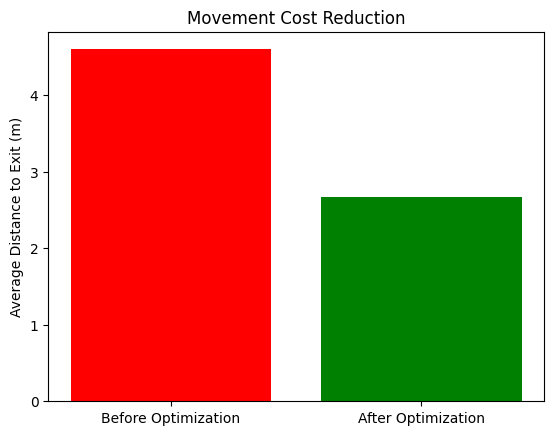

In [ ]:
# ----------------------------
# 7. Movement Cost Reduction
# ----------------------------
plt.bar(["Before Optimization", "After Optimization"], [avg_before, avg_after], color=['red', 'green'])
plt.ylabel("Average Distance to Exit (m)")
plt.title("Movement Cost Reduction")
plt.show()

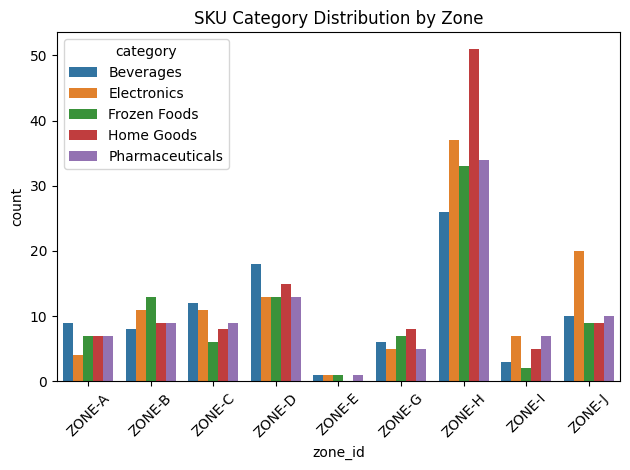

In [ ]:
# ----------------------------
# 8. SKU Category Distribution by Zone
# ----------------------------
cat_zone = alloc_df.groupby(['zone_id', 'category']).size().reset_index(name='count')
sns.barplot(data=cat_zone, x="zone_id", y="count", hue="category")
plt.title("SKU Category Distribution by Zone")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3973427333.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=utilization, x='zone_id', y='free_space_m3', palette='Blues')


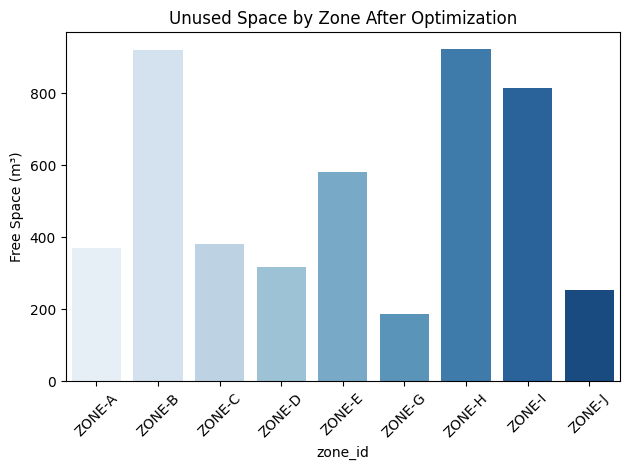

In [ ]:
# ----------------------------
# 9. Unused Space by Zone
# ----------------------------
utilization['free_space_m3'] = utilization['max_volume_m3'] - utilization['volume_m3']
sns.barplot(data=utilization, x='zone_id', y='free_space_m3', palette='Blues')
plt.title("Unused Space by Zone After Optimization")
plt.ylabel("Free Space (m³)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()